In [96]:
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/home/geantvert/.local/share/virtualenvs/kernl/bin/python -m pip install --upgrade pip' command.


In [97]:
data = dict()
with open("./data.csv") as f:
    for l in f:
        name, batch, seq_len, latency = l.split(",")
        data[(name, int(batch), int(seq_len))] = float(latency.strip())

In [98]:
speedup = dict()
for (name, batch, seq_len), latency in data.items():
    if name == "Baseline":
        continue
    if seq_len not in [16, 128, 256, 384, 512]:
        continue
    key = ("Baseline", batch, seq_len)
    if key not in data:
        continue
    baseline_latency = data[key]
    if name == "Kernl":
        name = "Kernl (this project)"
    speedup[(name, batch, seq_len)] = baseline_latency / latency

/tmp/ipykernel_3589230/1318777340.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[b_index].set_xticklabels(xticklabels)
/tmp/ipykernel_3589230/1318777340.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[b_index].set_yticklabels(y_ticks_labels)


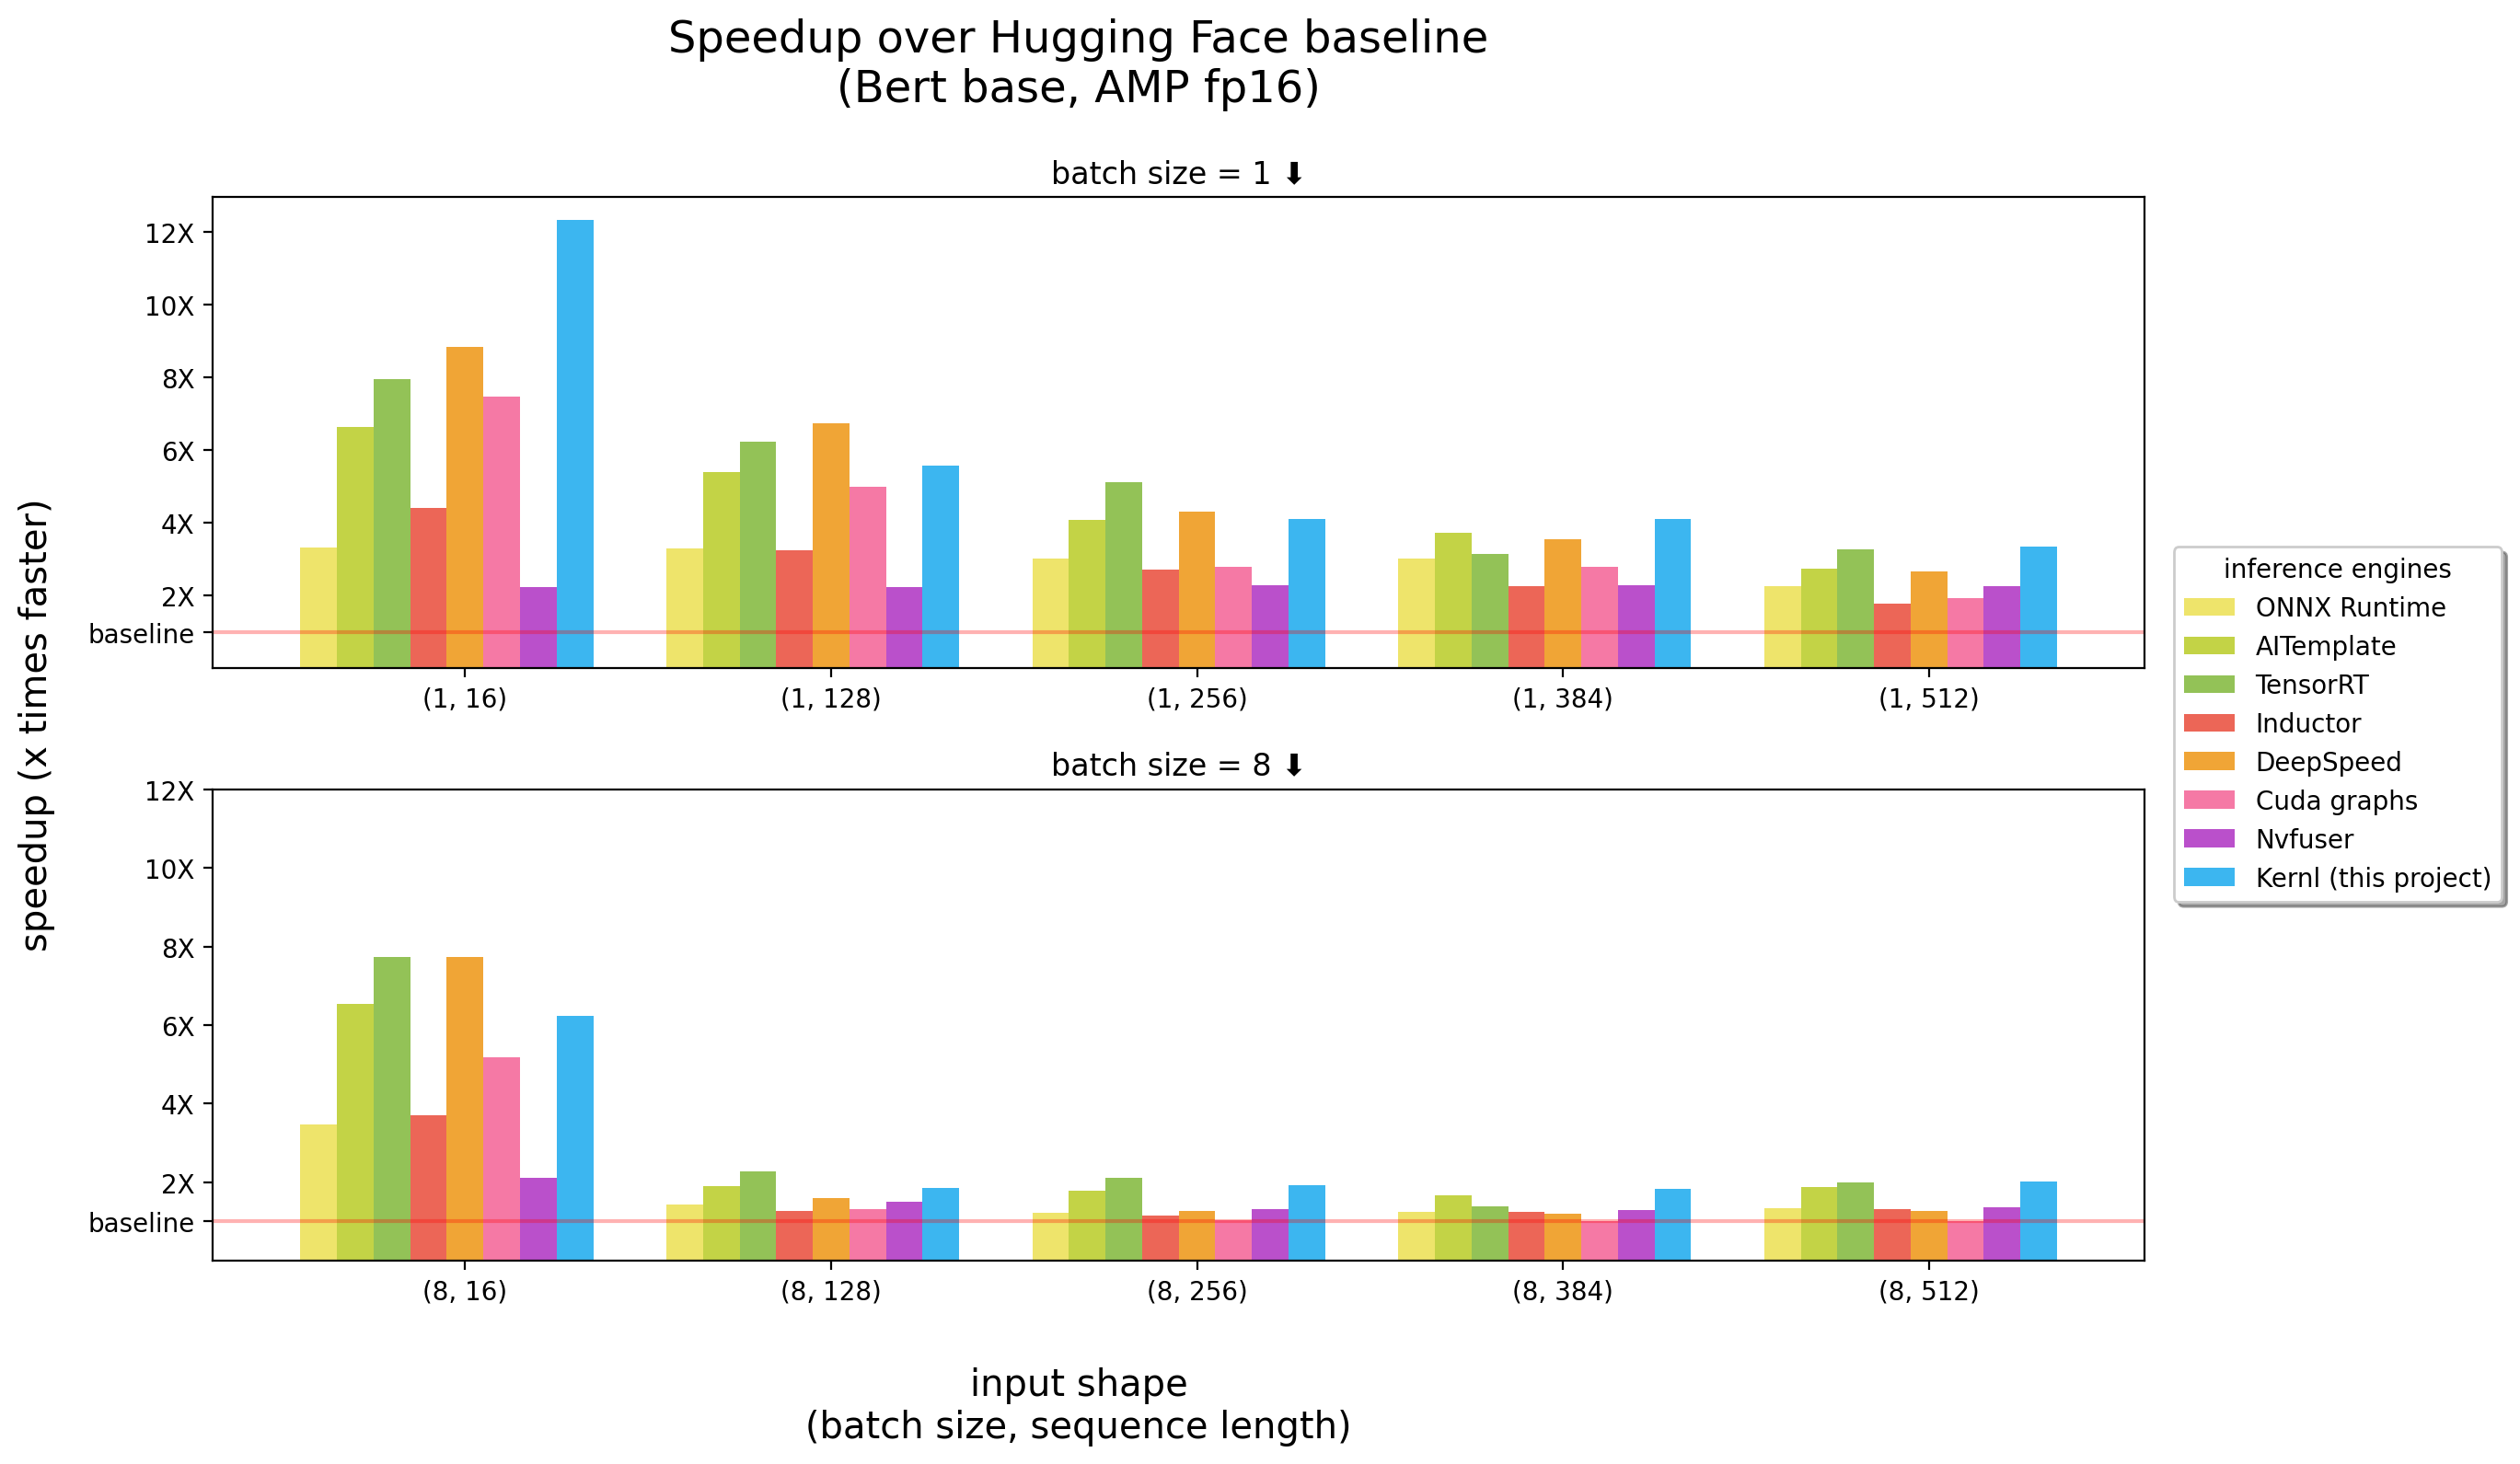

In [109]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

fig, ax = plt.subplots(2, figsize=(12, 8))
width = 0.1

engines = [
    "ONNX Runtime",
    "AITemplate",
    "TensorRT",
    "Inductor",
    "DeepSpeed",
    "Cuda graphs",
    "Nvfuser",
    "Kernl (this project)",
]
colors = ["#ede15b", "#bdcf32", "#87bc45", "#ea5545", "#ef9b20", "#f46a9b", "#b33dc6", "#27aeef", "#edbf33"]

batches = [1, 8]
seq_len = [16, 128, 256, 384, 512]
legend_box = list()

for idx_engine, (engine, color) in enumerate(zip(engines, colors)):
    for b_index, b in enumerate(batches):
        median_latencies = list()
        for s_l in seq_len:
            latency = speedup[(engine, b, s_l)]
            median_latencies.append(latency)
        rects = ax[b_index].bar(
            [v + idx_engine * width for v in range(len(median_latencies))],
            median_latencies,
            width,
            color=color,
            alpha=0.9,
        )
        if b_index == 0:
            legend_box.append(rects[0])

for b_index, b in enumerate(batches):
    ax[b_index].axhline(y=1, color="r", linestyle="-", alpha=0.3)
    xticklabels = [f"({b}, {s_l})" for s_l in seq_len]
    ax[b_index].set_xticklabels(xticklabels)
    ax[b_index].set_xticks([v + width * len(engines) / 2 for v in range(len(xticklabels))])

    y_ticks_labels = ["baseline"] + [f"{i}X" for i in range(2, 13, 2)]
    ax[b_index].set_yticklabels(y_ticks_labels)
    y_ticks = [1] + list(range(2, 13, 2))
    ax[b_index].set_yticks(y_ticks)


fig.suptitle("Speedup over Hugging Face baseline\n(Bert base, AMP fp16)", fontsize="xx-large")
ax[0].set_title("batch size = 1 ⬇")
ax[1].set_title("batch size = 8 ⬇")

fig.supxlabel("input shape\n(batch size, sequence length)", fontsize="x-large")
fig.supylabel("speedup (x times faster)", fontsize="x-large")
fig.tight_layout(pad=1.5)
fig.legend(
    legend_box, engines, loc="center right", ncols=1, bbox_to_anchor=(1.15, 0.5), shadow=True, title="inference engines"
)
plt.show()